<a href="https://colab.research.google.com/github/realnihal/Forecasting-COVID-19-cases/blob/main/COVID19_forecasting_using%20_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
url = 'https://api.covid19india.org/csv/latest/case_time_series.csv'
filename = 'case_time_series.csv'
urllib.request.urlretrieve(url, filename)

('case_time_series.csv', <http.client.HTTPMessage at 0x7f6c66c41110>)

In [2]:
import pandas as pd
df = pd.read_csv("case_time_series.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Date,,,,,,,
2020-01-30,2020-01-30,1,1,0,0,0,0
2020-01-31,2020-01-31,0,1,0,0,0,0
2020-02-01,2020-02-01,0,1,0,0,0,0
2020-02-02,2020-02-02,1,2,0,0,0,0
2020-02-03,2020-02-03,1,3,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562 entries, 2020-01-30 to 2021-08-13
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date_YMD         562 non-null    object
 1   Daily Confirmed  562 non-null    int64 
 2   Total Confirmed  562 non-null    int64 
 3   Daily Recovered  562 non-null    int64 
 4   Total Recovered  562 non-null    int64 
 5   Daily Deceased   562 non-null    int64 
 6   Total Deceased   562 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 35.1+ KB


In [4]:
daily_cases = pd.DataFrame(df["Daily Confirmed"]).rename(columns={"Daily Confirmed": "cases"})

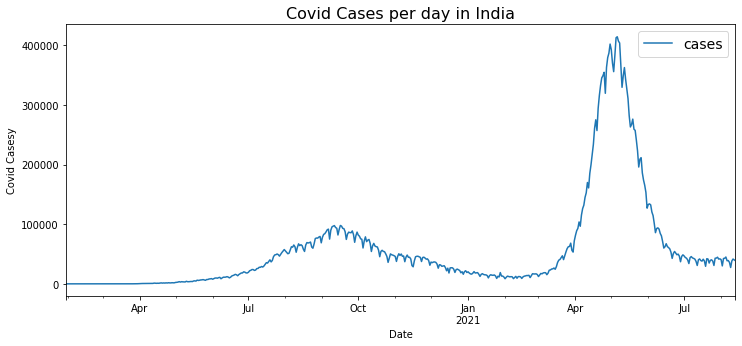

In [5]:
import matplotlib.pyplot as plt
daily_cases.plot(figsize=(12, 5))
plt.ylabel("Covid Casesy")
plt.title("Covid Cases per day in India", fontsize=16)
plt.legend(fontsize=14);

In [6]:
timesteps = daily_cases.index.to_numpy()
cases = daily_cases["cases"].to_numpy()
cases = cases/414280

In [7]:
split_size = int(0.8 * len(cases)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], cases[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], cases[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(449, 113, 449, 113)

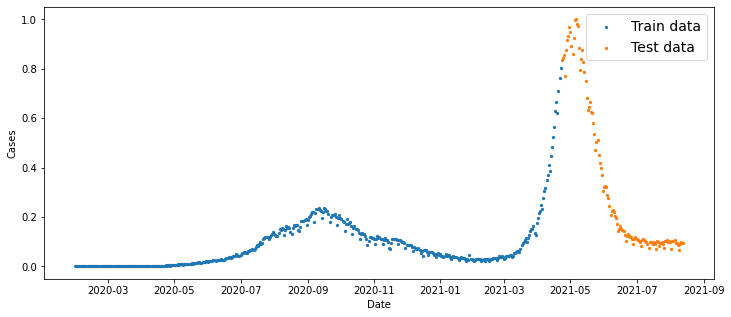

In [8]:
plt.figure(figsize=(12, 5))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend(fontsize=14)
plt.show();

In [9]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [10]:
HORIZON = 1
WINDOW_SIZE = 30 

In [11]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [12]:
import numpy as np
full_windows, full_labels = make_windows(cases, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(532, 532)

In [13]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [14]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(425, 107, 425, 107)

In [15]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) 

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow as tf
# Let's build an LSTM model with the Functional API

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = layers.Dropout(0.2)(x)
# this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
x = layers.Dropout(0.2)(x)
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.0005))

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history = model_5.fit(train_windows,
            train_labels,
            epochs=150,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [17]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 4ms/step - loss: 0.0271


0.027053499594330788

In [18]:
model_5.predict(cases[200:230].reshape(1,30))

array([[0.24044956]], dtype=float32)

In [19]:
def make_preds(pcases, model):
    no_of_preds = 100
    for i in range(no_of_preds):
        eval_case = pcases[-30:].reshape(1,30)
        pred = model.predict(eval_case)
        pcases = np.append(pcases,pred)
    return pcases
pred_cases = make_preds(cases, model_5)
pred_cases[-10:]

array([0.21659741, 0.20328695, 0.19203615, 0.18219881, 0.17360687,
       0.16575938, 0.1582801 , 0.15125737, 0.14482188, 0.13891993])

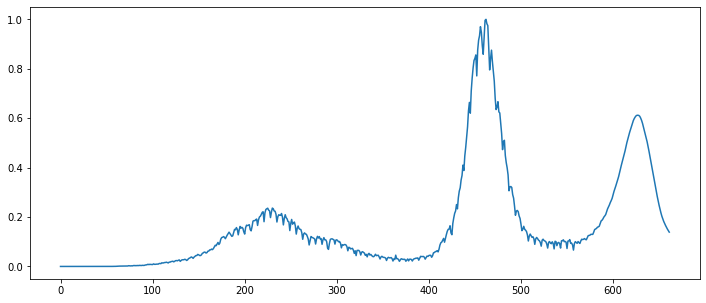

In [20]:
plt.figure(figsize=(12,5))
plt.plot(pred_cases)
plt.show()